## Data import

Here, we are generating the phase derivative from experimental data to use for classification and regression models.

In [1]:
import sys
sys.path.insert(0, '/Users/Soren/Documents/GitHub/sniffing-sensor')

seed = 42

In [2]:
from data.datasets import *
from data.data_functions import DataLoader, DerivTransform, NormalizeTransform

In [3]:
exp_derivs, labels = DataLoader(PureCompoundsInTallCuvettes(), transforms=[DerivTransform, NormalizeTransform]).load()

Loading experimental data
Pentane (1/11): [===================0] 100% complete
Hexane (2/11): [===================0] 100% complete
Heptane (3/11): [===================0] 100% complete
Octane (4/11): [===================0] 100% complete
Nonane (5/11): [===================0] 100% complete
Decane (6/11): [===================0] 100% complete
Ethanol (7/11): [===================0] 100% complete
Water (8/11): [===================0] 100% complete
Acetone (9/11): [===================0] 100% complete
Toluene (10/11): [===================0] 100% complete
Acetonitrile (11/11): [===================0] 100% complete
Length of experimental set loaded: 76


## Dataset split (train-test)

Perform a stratified train-test split based on the class labels

In [4]:
from sklearn.model_selection import train_test_split

In [5]:
X_train, X_test, y_train, y_test = train_test_split(list(labels.keys()), list(labels.values()), test_size=0.2, shuffle=True, random_state=seed, stratify=list(labels.values()))

## Model training

In [6]:
import numpy as np
import pandas as pd
from sklearn.svm import SVC
from sklearn.ensemble import VotingClassifier
from sklearn.model_selection import cross_validate, GridSearchCV

### Gridsearch

In [7]:
svm = SVC()

##### Coarse grid search

In [8]:
param_grid = {'C': [pow(10,n) for n in range(-8, 9, 2)], 'kernel': ['linear']}

grid_search = GridSearchCV(svm, param_grid, scoring='accuracy', cv=5, return_train_score=True)
hpo_coarse_results = grid_search.fit([exp_derivs[exp] for exp in X_train], y_train)

/Applications/anaconda3/envs/torch/lib/python3.8/site-packages/sklearn/model_selection/_split.py:666: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=5.
  warnings.warn(("The least populated class in y has only %d"


In [9]:
pd.DataFrame(hpo_coarse_results.cv_results_)[['param_C', 'mean_train_score', 'mean_test_score']].pivot_table(columns=['param_C'])

param_C,1.000000e-08,1.000000e-06,1.000000e-04,1.000000e-02,1.000000e+00,1.000000e+02,1.000000e+04,1.000000e+06,1.000000e+08
mean_test_score,0.166667,0.166667,0.166667,0.166667,0.366667,0.8000,0.833333,0.833333,0.833333
mean_train_score,0.183333,0.183333,0.183333,0.183333,0.391667,0.9625,1.000000,1.000000,1.000000


##### Fine grid search

In [10]:
param_grid = {'C': [pow(10,n) for n in np.linspace(1,4,11)], 'kernel': ['linear']}

grid_search = GridSearchCV(svm, param_grid, scoring='accuracy', cv=5, return_train_score=True)
hpo_coarse_results = grid_search.fit([exp_derivs[exp] for exp in X_train], y_train)

/Applications/anaconda3/envs/torch/lib/python3.8/site-packages/sklearn/model_selection/_split.py:666: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=5.
  warnings.warn(("The least populated class in y has only %d"


In [11]:
pd.DataFrame(hpo_coarse_results.cv_results_)[['param_C', 'mean_train_score', 'mean_test_score']].pivot_table(columns=['param_C'])

param_C,10.000000,19.952623,39.810717,79.432823,158.489319,316.227766,630.957344,1258.925412,2511.886432,5011.872336,10000.000000
mean_test_score,0.716667,0.733333,0.783333,0.8000,0.816667,0.833333,0.833333,0.833333,0.833333,0.833333,0.833333
mean_train_score,0.770833,0.862500,0.941667,0.9625,0.975000,0.987500,1.000000,1.000000,1.000000,1.000000,1.000000


### Cross-validation/dev

In [12]:
svm = SVC(C=300, kernel='linear')

In [13]:
cv_results = cross_validate(svm, [exp_derivs[exp] for exp in X_train], y_train, scoring='accuracy', cv=5, return_train_score=True, return_estimator=True)
{key:cv_results[key] for key in cv_results if key != 'estimator'}

/Applications/anaconda3/envs/torch/lib/python3.8/site-packages/sklearn/model_selection/_split.py:666: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=5.
  warnings.warn(("The least populated class in y has only %d"


{'fit_time': array([0.00323319, 0.00210094, 0.00122499, 0.00207782, 0.001863  ]),
 'score_time': array([0.00174594, 0.00044227, 0.00041509, 0.000453  , 0.0004549 ]),
 'test_score': array([0.66666667, 0.91666667, 0.83333333, 0.91666667, 0.75      ]),
 'train_score': array([1.        , 0.97916667, 0.97916667, 0.97916667, 1.        ])}

In [14]:
class Ens:
    def __init__(self, estimators):
        self.estimators = estimators
        self._estimator_type = 'classifier'
        
    def predict(self, X):
        final = []
        for x in X:
            predictions = []
            for est in self.estimators:
                predictions.append(est.predict([x])[0])
            final.append(max(set(predictions), key=predictions.count))
        return np.array(final)

In [15]:
single = svm.fit([exp_derivs[exp] for exp in X_train], y_train)
ensemble = Ens(cv_results['estimator'])

In [16]:
single = svm.fit([exp_derivs[exp] for exp in X_train], y_train)
ensemble = Ens(cv_results['estimator'])

### Metrics

In [17]:
from matplotlib import pyplot as plt
from sklearn.metrics import plot_confusion_matrix

0.8125


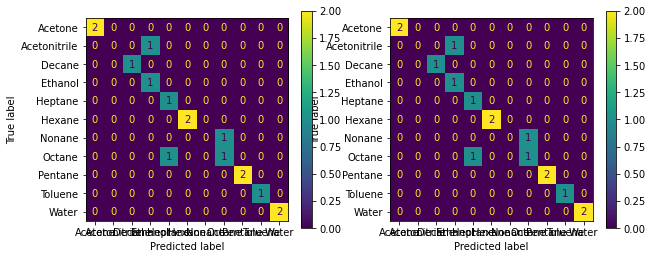

In [18]:
_, ax = plt.subplots(1,2, figsize=(10,4))

print(single.score([exp_derivs[exp] for exp in X_test], y_test))

plot_confusion_matrix(single, [exp_derivs[exp] for exp in X_test], y_test, ax=ax[0])
plot_confusion_matrix(ensemble, [exp_derivs[exp] for exp in X_test], y_test, ax=ax[1])